In [1]:
# Import libraries
## Basic libs
import pandas as pd
import numpy as np
import warnings
## Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump, load
import pickle
import joblib

# Configure libraries
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 10)
plt.style.use('seaborn')

In [2]:
# Load dataset
df_bank = pd.read_csv('bank.csv')


# print(df_bank.info())
print('Shape of dataframe:', df_bank.shape)
df_bank.head()

Shape of dataframe: (11162, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


## Class Distribution

In [3]:
df_bank['deposit'].value_counts()

no     5873
yes    5289
Name: deposit, dtype: int64

## Missing Values

In [4]:
df_bank.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

## Data preprocessing

In [5]:
# Copying original dataframe
df_bank_ready = df_bank.copy()

num_cols = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

# Z-scale for numerical columns
scaler = StandardScaler().fit(df_bank_ready[num_cols])
df_bank_ready[num_cols] = scaler.transform(df_bank_ready[num_cols])

df_bank_ready.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,1.491505,admin.,married,secondary,no,0.252525,yes,no,unknown,-1.265746,may,1042,-0.554168,-0.481184,-0.36326,unknown,yes
1,1.239676,admin.,married,secondary,no,-0.459974,no,no,unknown,-1.265746,may,1467,-0.554168,-0.481184,-0.36326,unknown,yes
2,-0.019470,technician,married,secondary,no,-0.080160,yes,no,unknown,-1.265746,may,1389,-0.554168,-0.481184,-0.36326,unknown,yes
3,1.155733,services,married,secondary,no,0.293762,yes,no,unknown,-1.265746,may,579,-0.554168,-0.481184,-0.36326,unknown,yes
4,1.071790,admin.,married,tertiary,no,-0.416876,no,no,unknown,-1.265746,may,673,-0.186785,-0.481184,-0.36326,unknown,yes


In [6]:
scaler.mean_

array([4.12319477e+01, 1.52853852e+03, 1.56580362e+01, 2.50842143e+00,
       5.13304067e+01, 8.32556889e-01])

In [7]:
# Onehot encoding
encoder = OneHotEncoder(sparse=False)
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Encode Categorical Data
df_encoded = pd.DataFrame(encoder.fit_transform(df_bank_ready[cat_cols]))
df_encoded.columns = encoder.get_feature_names(cat_cols)

# Replace Categotical Data with Encoded Data
df_bank_ready = df_bank_ready.drop(cat_cols ,axis=1)
df_bank_ready = pd.concat([df_encoded, df_bank_ready], axis=1)

# Encode target value
df_bank_ready['deposit'] = df_bank_ready['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

print('Shape of dataframe:', df_bank_ready.shape)
df_bank_ready.head()

Shape of dataframe: (11162, 52)


,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous,deposit
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.491505,0.252525,-1.265746,1042,-0.554168,-0.481184,-0.36326,1
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.239676,-0.459974,-1.265746,1467,-0.554168,-0.481184,-0.36326,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,-0.019470,-0.080160,-1.265746,1389,-0.554168,-0.481184,-0.36326,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.155733,0.293762,-1.265746,579,-0.554168,-0.481184,-0.36326,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.071790,-0.416876,-1.265746,673,-0.186785,-0.481184,-0.36326,1


## Split train-test

In [8]:
# Select Features
feature = df_bank_ready.drop('deposit', axis=1)

# Select Target
target = df_bank_ready['deposit']

# Set Training and Testing Data
X_train, X_test, y_train, y_test = train_test_split(feature , target, 
                                                    shuffle = True, 
                                                    test_size=0.2, 
                                                    random_state=1)

# Show the Training and Testing Data
print('Shape of training feature:', X_train.shape)
print('Shape of testing feature:', X_test.shape)
print('Shape of training label:', y_train.shape)
print('Shape of training label:', y_test.shape)

Shape of training feature: (8929, 51)
Shape of testing feature: (2233, 51)
Shape of training label: (8929,)
Shape of training label: (2233,)


In [9]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data 
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1, 'kappa': kappa, 
            'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm}

## Use 3 ML models
- Decision Tree
- Random forest
- NB

In [10]:
# Building Decision Tree model 
dtc = tree.DecisionTreeClassifier(random_state=0)
dtc.fit(X_train, y_train)

# Evaluate Model
dtc_eval = evaluate_model(dtc, X_test, y_test)

# Print result
print('Accuracy:', dtc_eval['acc'])
print('Precision:', dtc_eval['prec'])
print('Recall:', dtc_eval['rec'])
print('F1 Score:', dtc_eval['f1'])
print('Cohens Kappa Score:', dtc_eval['kappa'])
print('Area Under Curve:', dtc_eval['auc'])
print('Confusion Matrix:\n', dtc_eval['cm'])

Accuracy: 0.7863860277653381
Precision: 0.7866149369544132
Recall: 0.7593632958801498
F1 Score: 0.7727489280609815
Cohens Kappa Score: 0.5713461290033085
Area Under Curve: 0.7852610470817057
Confusion Matrix:
 [[945 220]
 [257 811]]


In [11]:
# Building Random Forest model 
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

# Evaluate Model
rf_eval = evaluate_model(rf, X_test, y_test)

# Print result
print('Accuracy:', rf_eval['acc'])
print('Precision:', rf_eval['prec'])
print('Recall:', rf_eval['rec'])
print('F1 Score:', rf_eval['f1'])
print('Cohens Kappa Score:', rf_eval['kappa'])
print('Area Under Curve:', rf_eval['auc'])
print('Confusion Matrix:\n', rf_eval['cm'])

Accuracy: 0.8584863412449619
Precision: 0.8286713286713286
Recall: 0.8876404494382022
F1 Score: 0.8571428571428572
Cohens Kappa Score: 0.7172751793804982
Area Under Curve: 0.9236461397502049
Confusion Matrix:
 [[969 196]
 [120 948]]


In [12]:
# Building Naive Bayes model 
nb = GaussianNB()
nb.fit(X_train, y_train)

# Evaluate Model
nb_eval = evaluate_model(nb, X_test, y_test)

# Print result
print('Accuracy:', nb_eval['acc'])
print('Precision:', nb_eval['prec'])
print('Recall:', nb_eval['rec'])
print('F1 Score:', nb_eval['f1'])
print('Cohens Kappa Score:', nb_eval['kappa'])
print('Area Under Curve:', nb_eval['auc'])
print('Confusion Matrix:\n', nb_eval['cm'])

Accuracy: 0.7196596506941334
Precision: 0.7862694300518135
Recall: 0.5683520599250936
F1 Score: 0.6597826086956522
Cohens Kappa Score: 0.43170220447138874
Area Under Curve: 0.8078519072189806
Confusion Matrix:
 [[1000  165]
 [ 461  607]]


In [13]:
# Building KNN model 
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Evaluate Model
knn_eval = evaluate_model(knn, X_test, y_test)

# Print result
print('Accuracy:', knn_eval['acc'])
print('Precision:', knn_eval['prec'])
print('Recall:', knn_eval['rec'])
print('F1 Score:', knn_eval['f1'])
print('Cohens Kappa Score:', knn_eval['kappa'])
print('Area Under Curve:', knn_eval['auc'])
print('Confusion Matrix:\n', knn_eval['cm'])

Accuracy: 0.780564263322884
Precision: 0.7794970986460348
Recall: 0.7546816479400749
F1 Score: 0.7668886774500475
Cohens Kappa Score: 0.5597152999707864
Area Under Curve: 0.8402702094484898
Confusion Matrix:
 [[937 228]
 [262 806]]


## Model comparison

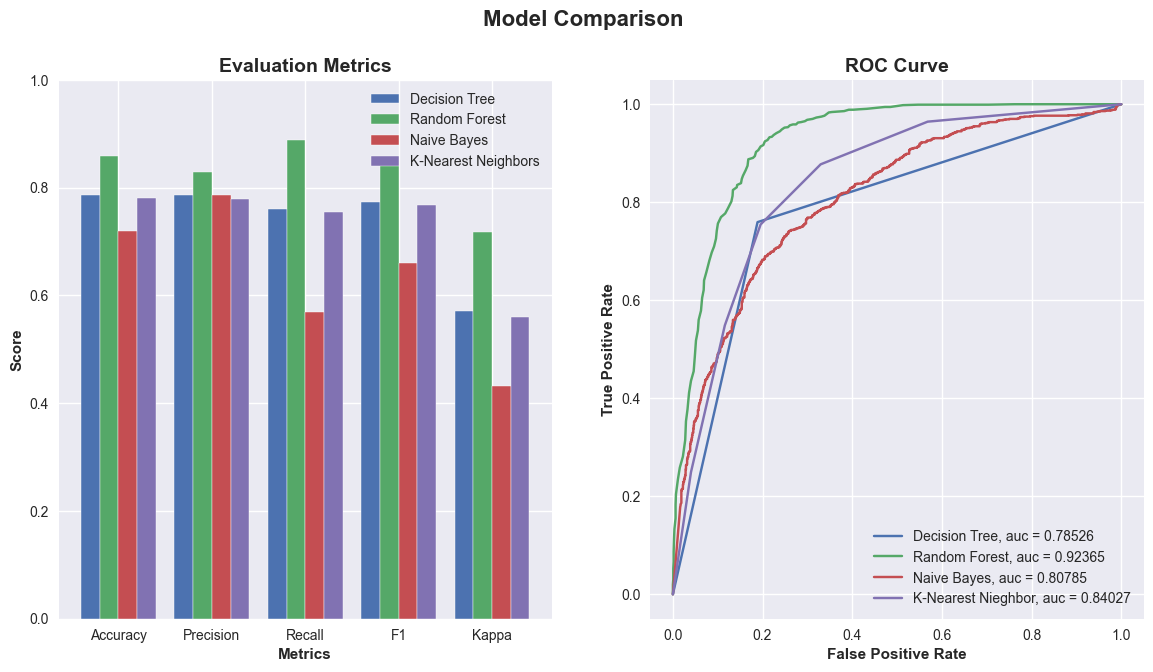

In [14]:
# Intitialize figure with two plots
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')
fig.set_figheight(7)
fig.set_figwidth(14)
fig.set_facecolor('white')

# First plot
## set bar size
barWidth = 0.2
dtc_score = [dtc_eval['acc'], dtc_eval['prec'], dtc_eval['rec'], dtc_eval['f1'], dtc_eval['kappa']]
rf_score = [rf_eval['acc'], rf_eval['prec'], rf_eval['rec'], rf_eval['f1'], rf_eval['kappa']]
nb_score = [nb_eval['acc'], nb_eval['prec'], nb_eval['rec'], nb_eval['f1'], nb_eval['kappa']]
knn_score = [knn_eval['acc'], knn_eval['prec'], knn_eval['rec'], knn_eval['f1'], knn_eval['kappa']]

## Set position of bar on X axis
r1 = np.arange(len(dtc_score))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

## Make the plot
ax1.bar(r1, dtc_score, width=barWidth, edgecolor='white', label='Decision Tree')
ax1.bar(r2, rf_score, width=barWidth, edgecolor='white', label='Random Forest')
ax1.bar(r3, nb_score, width=barWidth, edgecolor='white', label='Naive Bayes')
ax1.bar(r4, knn_score, width=barWidth, edgecolor='white', label='K-Nearest Neighbors')

## Configure x and y axis
ax1.set_xlabel('Metrics', fontweight='bold')
labels = ['Accuracy', 'Precision', 'Recall', 'F1', 'Kappa']
ax1.set_xticks([r + (barWidth * 1.5) for r in range(len(dtc_score))], )
ax1.set_xticklabels(labels)
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_ylim(0, 1)

## Create legend & title
ax1.set_title('Evaluation Metrics', fontsize=14, fontweight='bold')
ax1.legend()

# Second plot
## Comparing ROC Curve
ax2.plot(dtc_eval['fpr'], dtc_eval['tpr'], label='Decision Tree, auc = {:0.5f}'.format(dtc_eval['auc']))
ax2.plot(rf_eval['fpr'], rf_eval['tpr'], label='Random Forest, auc = {:0.5f}'.format(rf_eval['auc']))
ax2.plot(nb_eval['fpr'], nb_eval['tpr'], label='Naive Bayes, auc = {:0.5f}'.format(nb_eval['auc']))
ax2.plot(knn_eval['fpr'], knn_eval['tpr'], label='K-Nearest Nieghbor, auc = {:0.5f}'.format(knn_eval['auc']))

## Configure x and y axis
ax2.set_xlabel('False Positive Rate', fontweight='bold')
ax2.set_ylabel('True Positive Rate', fontweight='bold')

## Create legend & title
ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax2.legend(loc=4)

plt.show()

## Prediction

In [30]:
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,deposit_prediction
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,no
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,no
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,no
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,no
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,1,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,yes
11158,39,services,married,secondary,no,733,no,no,unknown,16,jun,83,4,-1,0,unknown,no,yes
11159,32,technician,single,secondary,no,29,no,no,cellular,19,aug,156,2,-1,0,unknown,no,yes
11160,43,technician,married,secondary,no,0,no,yes,cellular,8,may,9,2,172,5,failure,no,yes


In [15]:
feature

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.491505,0.252525,-1.265746,1042,-0.554168,-0.481184,-0.363260
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.239676,-0.459974,-1.265746,1467,-0.554168,-0.481184,-0.363260
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,-0.019470,-0.080160,-1.265746,1389,-0.554168,-0.481184,-0.363260
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.155733,0.293762,-1.265746,579,-0.554168,-0.481184,-0.363260
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.071790,-0.416876,-1.265746,673,-0.186785,-0.481184,-0.363260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,-0.691015,-0.473616,0.515650,257,-0.554168,-0.481184,-0.363260
11158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,-0.187357,-0.246658,0.040612,83,0.547981,-0.481184,-0.363260
11159,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,-0.774958,-0.464934,0.396891,156,-0.186785,-0.481184,-0.363260
11160,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.148416,-0.473926,-0.909466,9,-0.186785,1.109571,1.818332


In [25]:
feature.iloc[0:2]

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,poutcome_other,poutcome_success,poutcome_unknown,age,balance,day,duration,campaign,pdays,previous
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.491505,0.252525,-1.265746,1042,-0.554168,-0.481184,-0.36326
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.239676,-0.459974,-1.265746,1467,-0.554168,-0.481184,-0.36326


In [29]:
result = feature.iloc[0:2].to_json(orient="split")
parsed = json.loads(result)
print(json.dumps(parsed, indent=4))

{
    "columns": [
        "job_admin.",
        "job_blue-collar",
        "job_entrepreneur",
        "job_housemaid",
        "job_management",
        "job_retired",
        "job_self-employed",
        "job_services",
        "job_student",
        "job_technician",
        "job_unemployed",
        "job_unknown",
        "marital_divorced",
        "marital_married",
        "marital_single",
        "education_primary",
        "education_secondary",
        "education_tertiary",
        "education_unknown",
        "default_no",
        "default_yes",
        "housing_no",
        "housing_yes",
        "loan_no",
        "loan_yes",
        "contact_cellular",
        "contact_telephone",
        "contact_unknown",
        "month_apr",
        "month_aug",
        "month_dec",
        "month_feb",
        "month_jan",
        "month_jul",
        "month_jun",
        "month_mar",
        "month_may",
        "month_nov",
        "month_oct",
        "month_sep",
        "poutc

In [16]:
df_bank['deposit_prediction'] = rf.predict(feature)
df_bank['deposit_prediction'] = df_bank['deposit_prediction'].apply(lambda x: 'yes' if x==0 else 'no')


df_bank.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,deposit_prediction
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,no
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,no
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,no
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,no
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes,no
6,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes,no
7,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes,no
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes,no
9,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes,no


In [17]:
dump(rf, 'bank_deposit_classification.joblib')

['bank_deposit_classification.joblib']

In [18]:
## Save as a pickle file
filename= 'bank_deposit_classification.pkl'
joblib.dump(rf,open(filename, 'wb'))

In [19]:
rf

RandomForestClassifier(random_state=0)

In [20]:
encoder.transform(df_bank[cat_cols]).shape

(11162, 44)

In [21]:
encoder

OneHotEncoder(sparse=False)